In [13]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

### 1. Импорт и загрузка

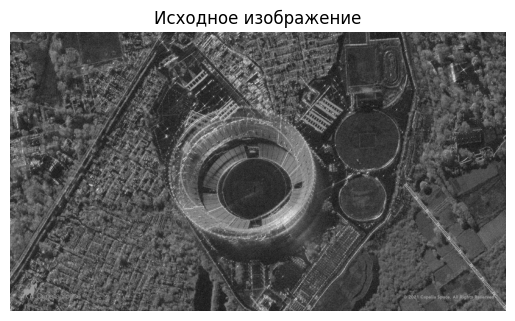

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# читаем SAR (градации серого)
sar = cv2.imread('sar_1.jpg', cv2.IMREAD_GRAYSCALE)
assert sar is not None, "sar_1.jpg не найден рядом с ноутбуком"

plt.imshow(sar, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()


### 2. Метрики (MSE и опционально SSIM)

In [15]:
def mse(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    return np.mean((a - b) ** 2)

try:
    from skimage.metrics import structural_similarity as ssim
    has_ssim = True
except ImportError:
    has_ssim = False
    ssim = None  # заглушка


### 3. NLM (несколько h) + печать метрик

In [16]:
nlm_h_vals = [5, 10, 20, 30]
nlm_results = []  # (h, denoise_img, MSE, SSIM/None)

for h in nlm_h_vals:
    den = cv2.fastNlMeansDenoising(sar, None, h=h,
                                   templateWindowSize=7,
                                   searchWindowSize=21)
    m = mse(sar, den)
    s = ssim(sar, den, data_range=255) if has_ssim else None
    nlm_results.append((h, den, m, s))

for h, img_den, m, s in nlm_results:
    if has_ssim:
        print(f"NLM h={h}: MSE={m:.2f}, SSIM={s:.4f}")
    else:
        print(f"NLM h={h}: MSE={m:.2f} (SSIM недоступен, нет scikit-image)")


NLM h=5: MSE=4.67, SSIM=0.9661
NLM h=10: MSE=44.63, SSIM=0.8202
NLM h=20: MSE=184.85, SSIM=0.5793
NLM h=30: MSE=277.34, SSIM=0.4657


### 4. Показать NLM-карты рядом

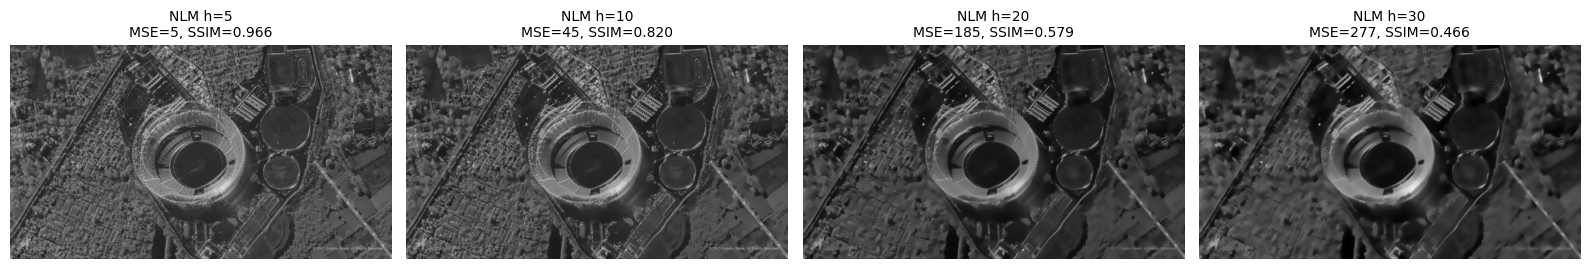

In [17]:
cols = len(nlm_results)
plt.figure(figsize=(4*cols, 4))
for i, (h, img_den, m, s) in enumerate(nlm_results, 1):
    plt.subplot(1, cols, i)
    plt.imshow(img_den, cmap='gray')
    title = f"NLM h={h}\nMSE={m:.0f}" + (f", SSIM={s:.3f}" if has_ssim else "")
    plt.title(title, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


### 4. Gaussian-фильтры (ядро 3/5/7 и σ=0/1/2) большой сеткой

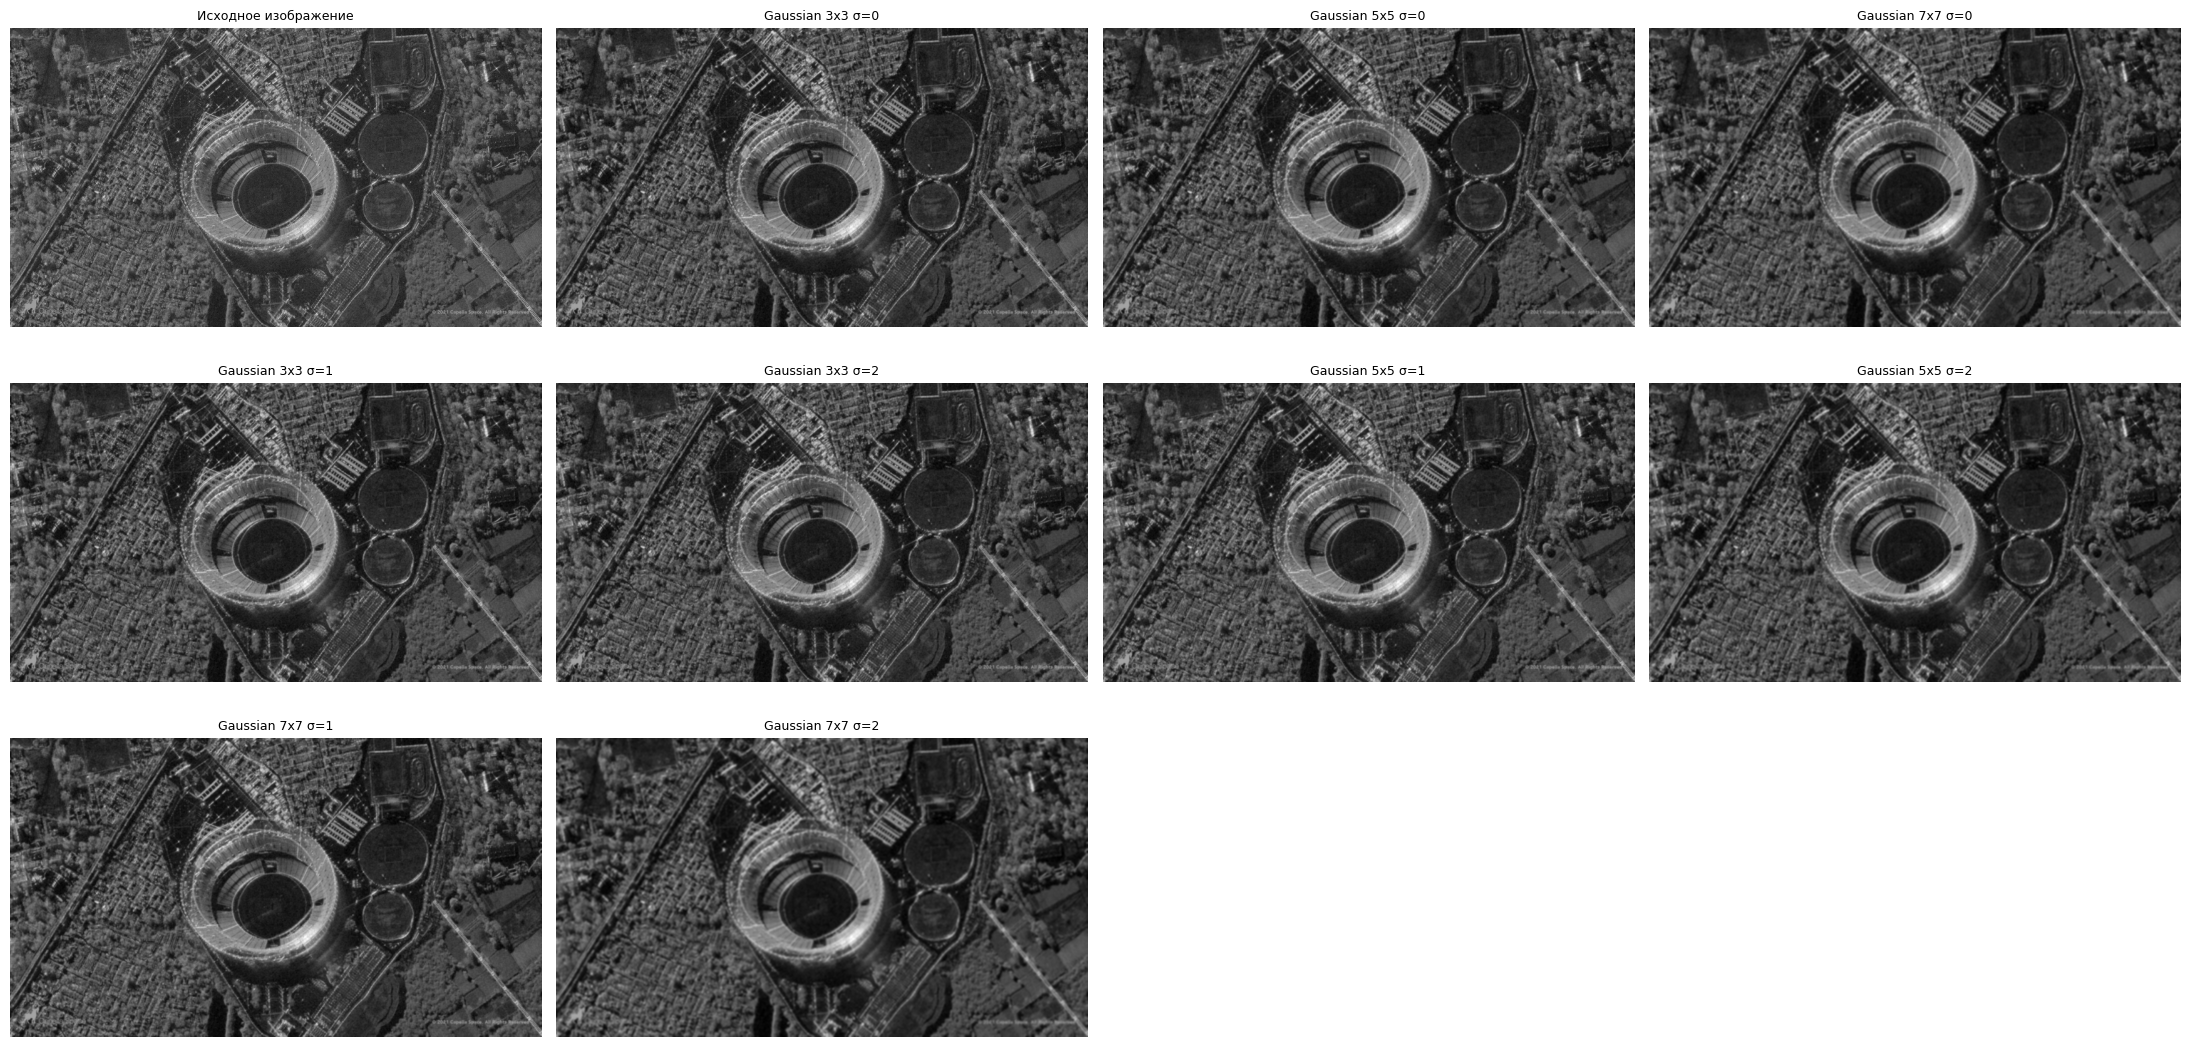

In [18]:
gauss_params = [
    ((3,3), 0), ((5,5), 0), ((7,7), 0),
    ((3,3), 1), ((3,3), 2),
    ((5,5), 1), ((5,5), 2),
    ((7,7), 1), ((7,7), 2),
]

gauss_imgs = [('Исходное изображение', sar)]
for k, sig in gauss_params:
    g = cv2.GaussianBlur(sar, k, sig)
    gauss_imgs.append((f"Gaussian {k[0]}x{k[1]} σ={sig}", g))

cols = 4
rows = int(np.ceil(len(gauss_imgs) / cols))

plt.figure(figsize=(22, 11))
for i, (title, im) in enumerate(gauss_imgs, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(im, cmap='gray')
    plt.title(title, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


### 5. Median-фильтры (3×3, 5×5, 7×7)

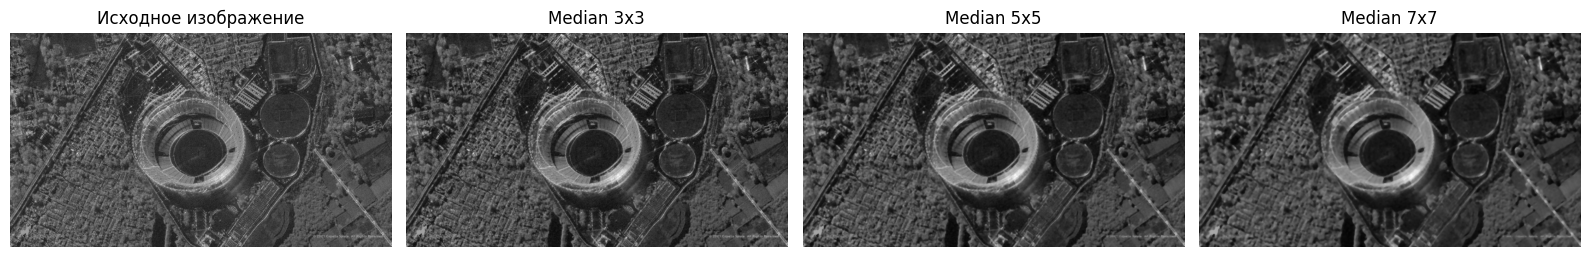

In [19]:
median_sizes = [3, 5, 7]
med_imgs = [('Исходное изображение', sar)]
for k in median_sizes:
    med_imgs.append((f"Median {k}x{k}", cv2.medianBlur(sar, k)))

plt.figure(figsize=(16, 4))
for i, (title, im) in enumerate(med_imgs, 1):
    plt.subplot(1, len(med_imgs), i)
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 6. Кто лучше

In [20]:
print("=== Gaussian (MSE к исходнику) ===")
for title, im in gauss_imgs[1:]:
    print(f"{title:>20} → {mse(sar, im):.2f}")

print("\n=== Median (MSE к исходнику) ===")
for title, im in med_imgs[1:]:
    print(f"{title:>20} → {mse(sar, im):.2f}")


=== Gaussian (MSE к исходнику) ===
    Gaussian 3x3 σ=0 → 63.40
    Gaussian 5x5 σ=0 → 109.96
    Gaussian 7x7 σ=0 → 163.18
    Gaussian 3x3 σ=1 → 73.21
    Gaussian 3x3 σ=2 → 93.61
    Gaussian 5x5 σ=1 → 100.30
    Gaussian 5x5 σ=2 → 171.45
    Gaussian 7x7 σ=1 → 103.52
    Gaussian 7x7 σ=2 → 207.14

=== Median (MSE к исходнику) ===
          Median 3x3 → 93.40
          Median 5x5 → 193.10
          Median 7x7 → 259.52


## 7. Зона-увеличение, чтобы глазами видеть разницу

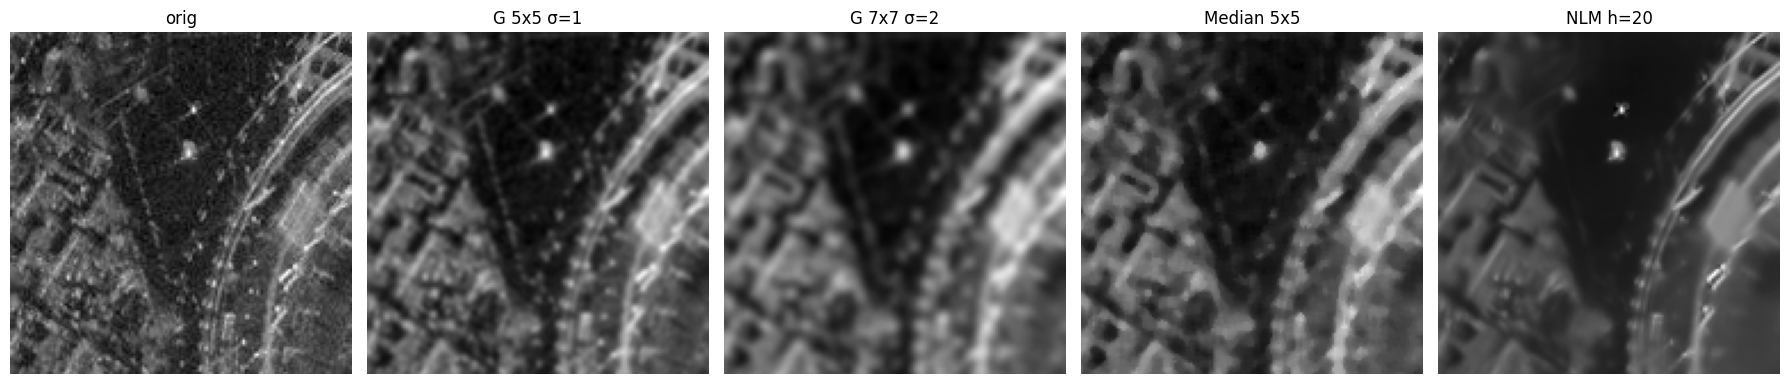

In [21]:
# координаты патча подстрой под своё изображение
y1, y2 = 200, 350
x1, x2 = 300, 450

def show_zoom(title_img_pairs, figsize=(18, 4)):
    plt.figure(figsize=figsize)
    for i, (t, im) in enumerate(title_img_pairs, 1):
        patch = im[y1:y2, x1:x2]
        plt.subplot(1, len(title_img_pairs), i)
        plt.imshow(patch, cmap='gray')
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_zoom([
    ('orig', sar),
    ('G 5x5 σ=1', cv2.GaussianBlur(sar, (5,5), 1)),
    ('G 7x7 σ=2', cv2.GaussianBlur(sar, (7,7), 2)),
    ('Median 5x5', cv2.medianBlur(sar, 5)),
    ('NLM h=20',  cv2.fastNlMeansDenoising(sar, None, h=20,
                                           templateWindowSize=7,
                                           searchWindowSize=21)),
])



**Итог.**
   - под аддитивный гауссов шум → Gaussian / NLM
   - под равномерный шум → Gaussian
   - под импульсный шум (s&p) → Median
